# Week 3: Fitting

In many different cases, we might have a model for how a system works, and want to fit that model to a set of observations.

We're going to investigate the process of fitting using a classic paper that proposed a model for the [T cell receptor](https://www.ncbi.nlm.nih.gov/pubmed/11606269). Here, the authors develop a mathematical model for how binding occurs and then have observations of how much binding occurs under specific conditions. Identifying whether and how this model fits has led to a better understanding of how our immune system recognizes diseased cells, and how to design T cells that respond to diseases like cancer.

In [1]:
# https://www.ncbi.nlm.nih.gov/pmc/articles/PMC1301723/

import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import least_squares

np.seterr(over='raise')

def Req_func(Phisum, Rtot, L0, KxStar, f, Ka):
    """ Mass balance. Transformation to account for bounds. """
    Req = Rtot / (1.0 + L0 * f * Ka * (1 + Phisum) ** (f - 1))
    return Phisum - Ka * KxStar * Req


def StoneMod(Rtot: float, Kd: float, v, Kx: float, L0: np.ndarray):
    '''
    Returns the number of mutlivalent ligand bound to a cell with Rtot
    receptors, granted each epitope of the ligand binds to the receptor
    kind in question with dissociation constant Kd and cross-links with
    other receptors with crosslinking constant Kx. All eq derived from Stone et al. (2001).
    '''
    v = np.int_(v)
    assert L0.shape == v.shape

    if Rtot <= 0.0:
        raise RuntimeError("You input a negative amount of receptor.")

    if Kx <= 0.0:
        raise RuntimeError("You input a negative Kx.")

    if np.amin(L0) <= 0.0:
        raise RuntimeError("You input a negative L0.")

    Ka = 1.0 / Kd
    KxStar = Kx / Ka

    ## Solve Req by calling least_squares
    lsq = least_squares(Req_func, np.ones_like(L0), jac="cs",
                        max_nfev=5000, xtol=1.0E-10, ftol=1.0E-10, gtol=1.0E-10,
                        args=(Rtot, L0, KxStar, v, Ka))

    if lsq['success'] is False:
        print(lsq)
        raise RuntimeError("Failure in solving for Req. If you see this message contact Dr. Meyer.")

    Phisum = lsq.x

    # Calculate L, according to equation 7
    Lbound = L0 / KxStar * ((1 + Phisum) ** v - 1)

    # Calculate Rmulti from equation 5
    Rmulti = L0 / KxStar * v * Phisum * ((1 + Phisum) ** (v - 1) - 1)

    # Calculate Rbound
    Rbnd = L0 / KxStar * v * Phisum * (1 + Phisum) ** (v - 1)

    return Lbound, Rbnd, Rmulti

Xs = np.array([8.1E-11, 3.4E-10, 1.3E-09, 5.7E-09, 2.1E-08, 8.7E-08, 3.4E-07, 1.5E-06, 5.7E-06, 2.82E-11, 1.17E-10, 4.68E-10, 1.79E-09, 7.16E-09, 2.87E-08, 1.21E-07, 4.5E-07, 1.87E-06, 1.64E-11, 6.93E-11, 2.58E-10, 1.11E-09, 4.35E-09, 1.79E-08, 7.38E-08, 2.9E-07, 1.14E-06])
Ys = np.array([-196, -436, 761, 685, 3279, 7802, 11669, 12538, 9012, -1104, -769, 1455, 2693, 7134, 11288, 14498, 16188, 13237, 988, 1734, 4491, 9015, 13580, 17159, 18438, 18485, 17958])
Vs = np.repeat([2, 3, 4], 9)

#### (1) We will fit the data contained within Fig. 3B. Plot this data and describe the relationship you see between Kx, Kd, and valency.

**As valency increases, the charted graphs move up higher. In other words, at the higher valencies, the measurement of response is higher for the same concentration of oligomers, although they still follow similar shapes.**

**Note that I did not discuss Kx and Kd because Prof Meyer said on slack, in response to someone inquiring about it: "Good point about question 1. You can just talk about the effect of valency."**

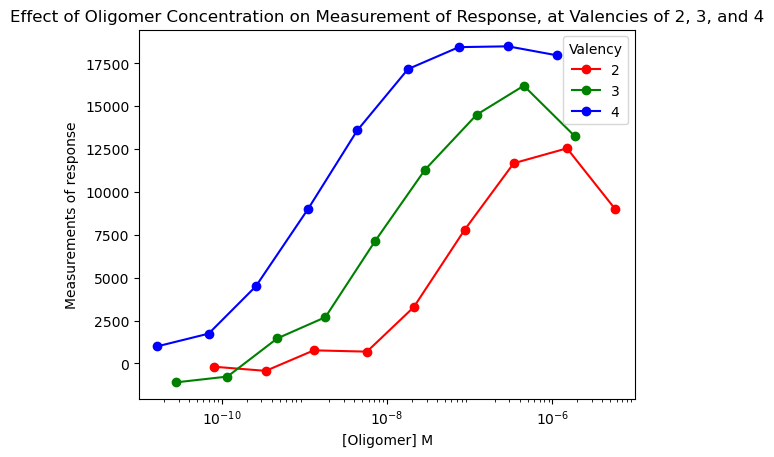

In [2]:
# Note that Xs are the concentrations from the experiment
# Vs are the complex valencies
# Ys are the measurements of response
# Each of these vectors is the same length, with each position describing an experimental measurement

def plot_valency_data(Xs_in, Ys_in, Vs_in, colorsinput, format='o-'):
    """If you pass in your real or simulated data, this will plot it for you."""
    colors = colorsinput
    for valency in range(3):
        plt.semilogx(Xs_in[Vs_in == valency + 2],
                     Ys_in[Vs_in == valency + 2],
                     colors[valency] + format)

    plt.xlim([1E-11, 1E-5])
    plt.xticks([1E-10, 1E-8, 1E-6])
    plt.xlabel('[Oligomer] M')
    plt.ylabel('Measurements of response')

########
colorsinput = ['r', 'g', 'b']
plot_valency_data(Xs, Ys, Vs, colorsinput, 'o-')
plt.title("Effect of Oligomer Concentration on Measurement of Response, at Valencies of 2, 3, and 4")
plt.legend(('2', '3', '4'), title = "Valency")

########

#### (2) First, to do so, we'll need a function that takes the model predictions, scales them to the units of the actual measurements, and finds the predictions for each condition. Define a scaling parameter and a function that takes it along with the other parameters to make predictions about the experiment.

Use the fit parameters shown in Table 1 (row 2) and overlay with the measurements to ensure your function is working. (Scale = 1 for now.)

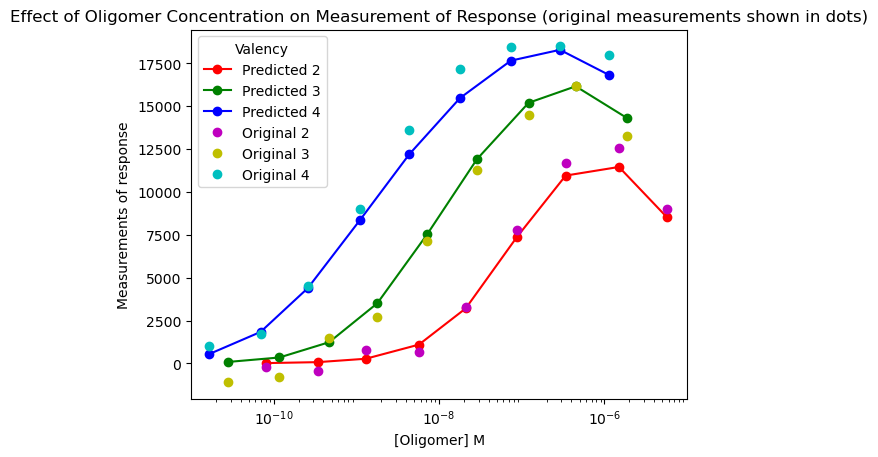

In [3]:
# Here is a scaling function
# Note that the unknown parameters are passed in as an array
# This will make working with least_squares() easier later
####Kd in M, Kx in cell

scale = 1
Kd = 1.70*10**-6
Kx = 3.15*10**-4
Rtot = 24000.0  # cell^-1
parameters = [scale, Kd, Kx]

def scale_StoneMod(parameters, Vs, Xs):

    Lbound, Rbnd, Rmulti = StoneMod(Rtot, parameters[1], Vs, parameters[2], Xs)
    return parameters[0] * Rmulti


#print(scale_StoneMod(parameters, Vs, Xs))
colorsinput = ['r', 'g', 'b']
plot_valency_data(Xs, (scale_StoneMod(parameters, Vs, Xs)), Vs, colorsinput)
colorsinput = ['m', 'y', 'c']
plot_valency_data(Xs, Ys, Vs, colorsinput, 'o')

#making pretty

plt.title("Effect of Oligomer Concentration on Measurement of Response (original measurements shown in dots)")
plt.legend(('Predicted 2', 'Predicted 3', 'Predicted 4', 'Original 2', 'Original 3', 'Original 4'), title = "Valency")
plt.show()

#### (3) Now use `scipy.optimize.least_squares` to find the least squares solution.

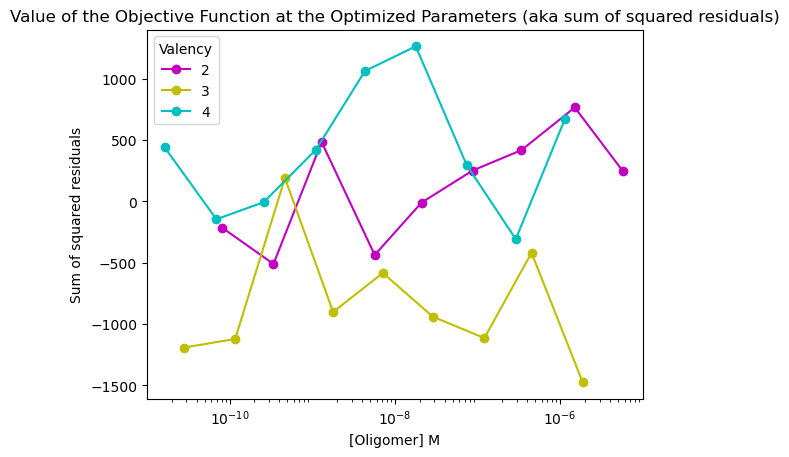

In [4]:
## You will need a function that returns the residuals:
def residuals(parameters, Vs_in, Xs_in, Ys_in):
    return Ys_in - scale_StoneMod(parameters, Vs_in, Xs_in)

# Note that the data (Xs, Ys) are not unknowns, so they should be passed in using the args argument of least_squares

# With this function, your least squares call should look something like this:
# lsq_solution = least_squares(residuals, params_guess, args=(Vs, Xs, Ys))

# Answer

residuals(parameters, Vs, Xs, Ys)
#print(residuals)
params = [scale, Kd, Kx]
lsq_solution = least_squares(residuals, params, args=(Vs, Xs, Ys))

#print(lsq_solution)
# this bit is for me to look at

# printing this to see how close the least squares solution is, visually
#############################
#THIS IS NOT MY ANSWER TO THE QUESTION: THAT GRAPH IS DOWN BELOW ONE BLOCK
#############################
colorsinput = ['m', 'y', 'c']
#plot_valency_data(Xs, lsq_solution.fun, Vs, colorsinput)
plot_valency_data(Xs, lsq_solution.fun, Vs, colorsinput)
plt.title("Value of the Objective Function at the Optimized Parameters (aka sum of squared residuals)")
plt.legend(('2', '3', '4'), title = "Valency")
plt.ylabel('Sum of squared residuals')
plt.show()

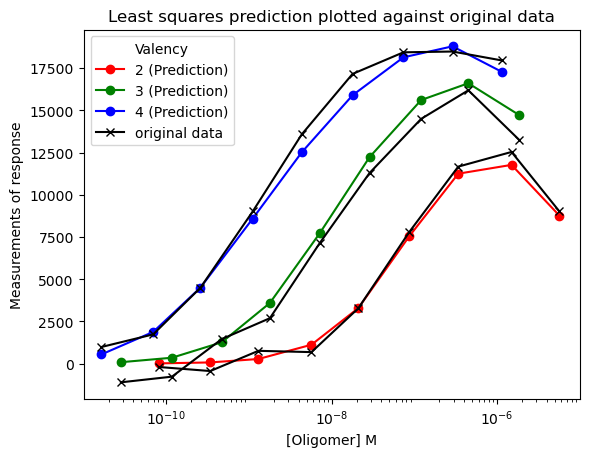

In [5]:
predictions2 = scale_StoneMod(lsq_solution.x, Vs, Xs)
colorsinput = ['r', 'g', 'b']
plot_valency_data(Xs, predictions2, Vs, colorsinput)

colorsinput = ['k', 'k', 'k']
plot_valency_data(Xs, Ys, Vs, colorsinput, 'x-')

plt.title("Least squares prediction plotted against original data")
plt.legend(('2 (Prediction)', '3 (Prediction)', '4 (Prediction)', 'original data'), title = "Valency")

**The first graph is for funsies! Please consider the second one for q3**

#### (4) Using leave-one-out crossvalidation, does this model predict the data? Plot the measured vs. predicted data.


**Yes, the model predicts the data decently well. Looking at the actual Ys and the lsq_predictions, they're typically close and capture the general trend of the data. Also, looking at the arrays printed, Ys and lsq predictions seem to be pretty close. I also added a section that does the % error (the one I did is (actual-expected)/expected*100%) and it seems pretty good :D**

**Note this was not a requirement, but it seems that there are a few points that have pretty big errors, but for the most part, they're quite close (within e0 or e1), which makes me more confident in saying that yes, the model does predict the data quite well.**

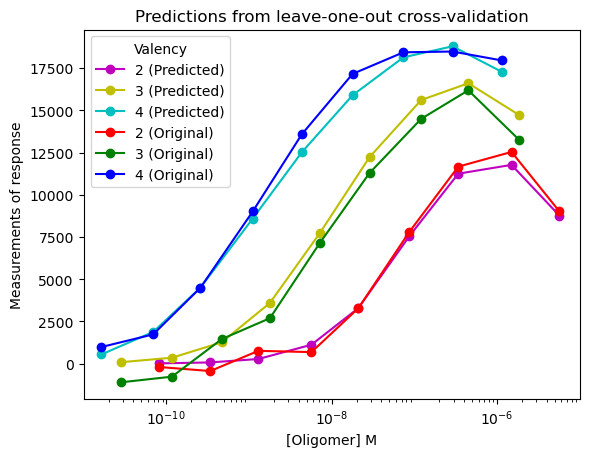

[-1.20715165e+03 -6.89780657e+02  1.74356695e+02 -3.89400412e+01
 -3.05827695e-01  3.32603824e+00  3.71647143e+00  6.50424058e+00
  2.83418544e+00 -1.36055805e+03 -3.18217596e+02  1.50185087e+01
 -2.50883089e+01 -7.56092591e+00 -7.68474404e+00 -7.13800671e+00
 -2.51959458e+00 -1.00266047e+01  8.05628294e+01 -7.74736675e+00
 -1.55030929e-01  4.91041074e+00  8.49135799e+00  7.95326149e+00
  1.63844497e+00 -1.63833538e+00  3.88801782e+00]


In [6]:
# scikit-learn provides a great interface for getting indices that help you split the data
from sklearn.model_selection import LeaveOneOut
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score, cross_val_predict, KFold
from sklearn.metrics import r2_score
import scipy as sp

lsq_predictions = np.zeros(len(Ys))
Xs_pred = np.zeros(len(Xs))
Vs_pred = np.zeros(len(Vs))

for train_idx, test_idx in LeaveOneOut().split(Vs):
    Vs_training = Vs[train_idx]
    Vs_testing = Vs[test_idx]

    Xs_training = Xs[train_idx]
    Xs_testing = Xs[test_idx]

    Ys_training = Ys[train_idx]
    Ys_testing = Ys[test_idx]

    lsq_parameters_cv = least_squares(residuals, params, args=(Vs_training, Xs_training, Ys_training))
    lsq_predictions[test_idx] = scale_StoneMod(lsq_solution.x, Vs_testing, Xs_testing)
    Xs_pred[test_idx] = Xs_testing
    Vs_pred[test_idx] = Vs_testing

# Answer
colorsinput = ['m', 'y', 'c']

plot_valency_data(Xs_pred, lsq_predictions, Vs_pred, colorsinput)
colorsinput = ['r', 'g', 'b']
plot_valency_data(Xs, Ys, Vs, colorsinput)
plt.title("Predictions from leave-one-out cross-validation")
plt.legend(('2 (Predicted)', '3 (Predicted)', '4 (Predicted)', '2 (Original)', '3 (Original)', '4 (Original)'), title = "Valency")
plt.show()

#### Finding percent error to get an intuitive understanding of how close the predicted fits the actual.
#there are a few points that have pretty big errors, but for the most part, they're quite close (within e0 or e1)
percent_error=np.zeros(27)
percent_error = ((Ys-lsq_predictions)/lsq_predictions)*100
print(percent_error)


#### (5) Using bootstrap estimation, plot the confidence interval of the model predictions along with the data points.
"Confidence interval" does not have a precise definition. For example, you could show the interval over which 50% of the bootstrap samples fall (25th to 75th quantile).

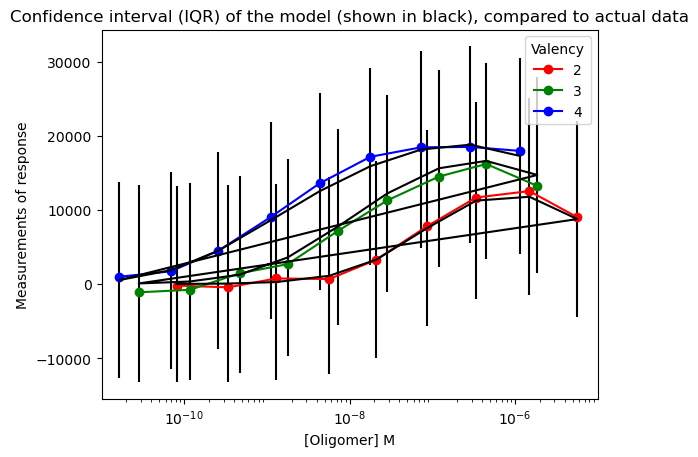

In [7]:
# sklearn has a very useful resample function
from sklearn.utils import resample
from scipy.stats import iqr

# For example, to resample the data, you can do this:
#resamp = resample(range(Vs.size))
#Vs_resampled = Vs[resamp]
#Xs_resampled = Xs[resamp]
#Ys_resampled = Ys[resamp]

bootstrap = []
for i in range(100):
  resamp = resample(range(Vs.size))
  Vs_resampled = Vs[resamp]
  Xs_resampled = Xs[resamp]
  Ys_resampled = Ys[resamp]
  lsq_solution2 = least_squares(residuals, params, args=(Vs_resampled, Xs_resampled, Ys_resampled))
  bootstrap.append(scale_StoneMod(lsq_solution2.x, Vs, Xs))

plt.errorbar(Xs,scale_StoneMod(lsq_solution.x, Vs, Xs), iqr(bootstrap), color = 'k')

colorsinput = ['r', 'g', 'b']
plot_valency_data(Xs, Ys, Vs, colorsinput)
plt.legend(('2', '3', '4'), title = "Valency")
plt.title("Confidence interval (IQR) of the model (shown in black), compared to actual data")
plt.show()

#### (6) _Generally_, how would you expect the cross-validation and bootstrap results to change if you had fewer data points?

Explain your answer.

**1) I would expect the cross-validation to exhibit more poor performance and higher variance. This is because with less data, there would be fewer samples in each fold - which leads to higher variability for the predictions. The parameters are also trained 'less' accurately, simply because there is less data.**

**2) Bootstrapping tells us how much the model varies when given resampled data from the available dataset- this also increases with a smaller sample size, as we have less data points for it to build the model off of - and is thus weaker to interference from outliers (increasing bias).**

#### (7) Now, we will perform a local sensitivity analysis to look at the dependence of the model results on each parameter. Vary each parameter up and down relative to its optimum by 10-fold **while holding the others constant**, and plot the sum of squared error. Which parameter affects the error the most? Which one the least?

You should get a plot that roughly looks like a "U" for each parameter. Use a log-log plot to show the variation the best (`plt.loglog`).

**Scale affects the errors the most, while Ks error affects it the least.This is because the steeper the slope, the more the parameter affects the error (it is the most sensitive) - and scale has by far the steepest slope. On the other hand, the shallower the slope, the less the parameter affects the error (it is the least sensitive) - and Ks has the shallowest slope.**

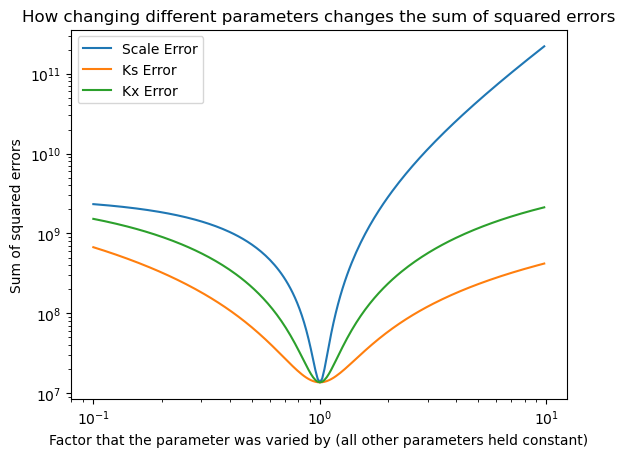

In [8]:
#setting up the modifications we want to do to the parameters
param_mods = np.power(10.0, np.arange(-1, 1, 0.01))

#creating empty vectors to store the sum of least square errors for each param
scale_error = []
ks_error = []
kx_error = []

#carrying it out
for param_mod in param_mods:
  fit_parameters = lsq_solution.x.copy()
  fit_parameters[0]*=param_mod
  res = residuals(fit_parameters, Vs, Xs, Ys)
  scale_error.append(sum(np.square(res)))
for param_mod in param_mods:
  fit_parameters = lsq_solution.x.copy()
  fit_parameters[1]*=param_mod
  res = residuals(fit_parameters, Vs, Xs, Ys)
  ks_error.append(sum(np.square(res)))

for param_mod in param_mods:
  fit_parameters = lsq_solution.x.copy()
  fit_parameters[2]*=param_mod
  res = residuals(fit_parameters, Vs, Xs, Ys)
  kx_error.append(sum(np.square(res)))


plt.loglog(param_mods, scale_error)
plt.loglog(param_mods, ks_error)
plt.loglog(param_mods, kx_error)

#making graph pretty
plt.xlabel('Factor that the parameter was varied by (all other parameters held constant)')
plt.ylabel('Sum of squared errors')
plt.legend(('Scale Error', 'Ks Error', 'Kx Error'))
plt.title("How changing different parameters changes the sum of squared errors")
plt.show()
